In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import re
import csv
from datetime import datetime, timedelta

In [2]:
# parameters
minimum_duration = 5
first_or_last_crossing = 'first'

# detection parameters
Npix_min = 2025#20*6*5
Npix_max = 500*6*5
OW_thr_factor =-0.7

sigma = 9 # smoothing parameter

experiment_name = 'INALT60.L120-KRS0020'
data_resolution = '1d'

In [3]:
datestart, dateend = "2012-04-10", "2012-05-04"
#periods = [
#    ("2012-01-01", "2012-01-25"), ("2012-01-26", "2012-02-19"), ("2012-02-20", "2012-03-15"),
#    ("2012-03-16", "2012-04-09"), ("2012-04-10", "2012-05-04"), ("2012-05-05", "2012-05-29"),
#    ("2012-05-30", "2012-06-28"), ("2012-10-27", "2012-11-20"), ("2012-11-21", "2012-12-15"),
#    
#    ("2012-06-29", "2012-07-28"), ("2012-07-29", "2012-08-27"), ("2012-08-28", "2012-09-26"), ("2012-09-27", "2012-10-26"),
#]

In [4]:
depth= 0  #corresponding to... 
depth_index = 0 # tracking only on surface

#mesh_mask = xr.open_dataset('/gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/suppl/2_INALT60.L120-KRS0020_mesh_mask.nc') 
#depth_information = [(round(mesh_mask.nav_lev.values[i]), i) for i in range(0, 64, 3)] #upper 1000m, otherwise: range(0, len(mesh_mask.nav_lev.values), 3)
#print(depth_information)

In [5]:
outpath = f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/depth-{depth}/'   ## !! SMOOTHED !!

data_path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/INALT60.L120-KRS0020/nemo/'
mesh_mask = xr.open_dataset(data_path + 'suppl/2_INALT60.L120-KRS0020_mesh_mask.nc')

ds_ACT_coords = xr.open_dataset('/gxfs_work/geomar/smomw523/eddytools/CHRISTINA_Parcels_sections_ACT.nc')


In [6]:
line_left_lon = ds_ACT_coords.lon.where(ds_ACT_coords.section_number == 5, drop=True).values
line_left_lat = ds_ACT_coords.lat.where(ds_ACT_coords.section_number == 5, drop=True).values

line_up_lon = ds_ACT_coords.lon.where(ds_ACT_coords.section_number == 6, drop=True).values
line_up_lat = ds_ACT_coords.lat.where(ds_ACT_coords.section_number == 6, drop=True).values

combined_lon = np.concatenate((line_left_lon, line_up_lon))
combined_lat = np.concatenate((line_left_lat, line_up_lat))

In [ ]:
filename = f'Tracks_{datestart.replace("-", "")}_{dateend.replace("-", "")}_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}.pickle'
tracks = np.load(outpath + filename, allow_pickle=True)
start_date = datetime.strptime(re.search(r'Tracks_(\d{8})_', filename).group(1), '%Y%m%d')

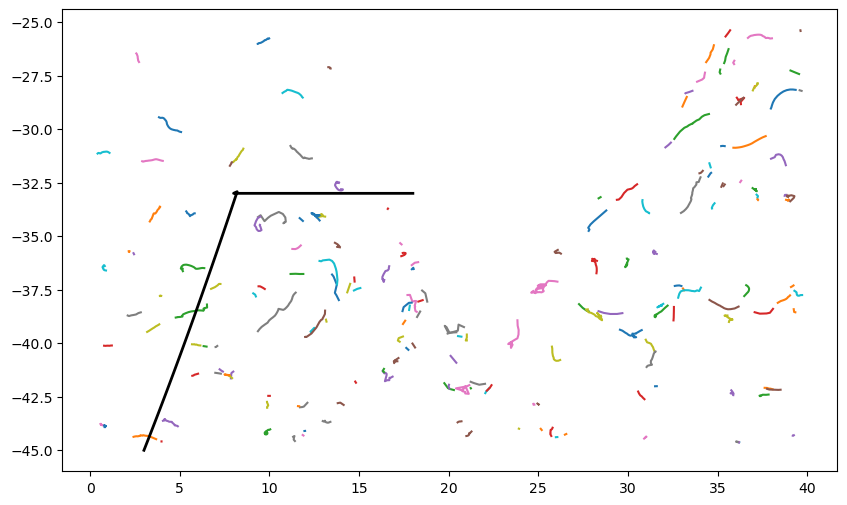

In [8]:
plt.figure(figsize=(10, 6))
for track in tracks:
    lon = track['lon']
    lat = track['lat']
    plt.plot(lon, lat)
plt.plot(combined_lon, combined_lat, color='black',linewidth=2)

In [9]:
def check_if_crossed(track_lon, track_lat, line_lon, line_lat, first_or_last_crossing="last"):
    """
    Where does an eddy track cross a section?

    Arguments:
    - track_lon, track_lat: lons and lats of eddy track
    - line_lon, line_lat: lons and lats of section
    - first_or_last_crossing: returning first or last crossing of eddy?, default: last
    
    Returning:
    - time index of eddy crossing (or None for no crossing)
    """
    def is_on_opposite_sides(p1, p2, l1, l2):
        """Are 2 consecutive positions of an eddy along track on opposite sides of the section, i.e. does it cross?"""
        vec_line = np.array([l2[0] - l1[0], l2[1] - l1[1]])  # Section as direction vector
        vec_p1 = np.array([p1[0] - l1[0], p1[1] - l1[1]])    # Position at time x relative to section
        vec_p2 = np.array([p2[0] - l1[0], p2[1] - l1[1]])    # Position at time x+1 relative to section

        cross1 = np.cross(vec_line, vec_p1)
        cross2 = np.cross(vec_line, vec_p2)

        # Eddy crossed / positions on opposite sides of section if the signs are different
        return cross1 * cross2 < 0

    def is_within_bounds(p, l1, l2):
        """ Actually crossing the section? The above function uses a direction vector along the section but doesn't end.""" 
        return (min(l1[0], l2[0]) <= p[0] <= max(l1[0], l2[0]) and
                min(l1[1], l2[1]) <= p[1] <= max(l1[1], l2[1]))

    last_crossing_index = None

    # Iterating for the whole track length
    for i in range(1, len(track_lon)):
        point1 = (track_lon[i - 1], track_lat[i - 1])
        point2 = (track_lon[i], track_lat[i])
        line_start = (line_lon[0], line_lat[0])
        line_end = (line_lon[-1], line_lat[-1])

        if is_on_opposite_sides(point1, point2, line_start, line_end):
            # Calculate section point
            t = np.dot(np.array(line_end) - np.array(line_start), np.array(point1) - np.array(line_start)) / \
                np.dot(np.array(line_end) - np.array(line_start), np.array(line_end) - np.array(line_start))
            intersection = (line_start[0] + t * (line_end[0] - line_start[0]),
                            line_start[1] + t * (line_end[1] - line_start[1]))

            # Crossing in right direction?
            if is_within_bounds(intersection, line_start, line_end):
                lon_direction = track_lon[i] - track_lon[i - 1]  # < 0 from east to west
                lat_direction = track_lat[i] - track_lat[i - 1]  # > 0 from south to north
                if lon_direction < 0 or lat_direction > 0:
                    if first_or_last_crossing == "first":
                        return i
                    elif first_or_last_crossing == "last":
                        last_crossing_index = i

    return last_crossing_index


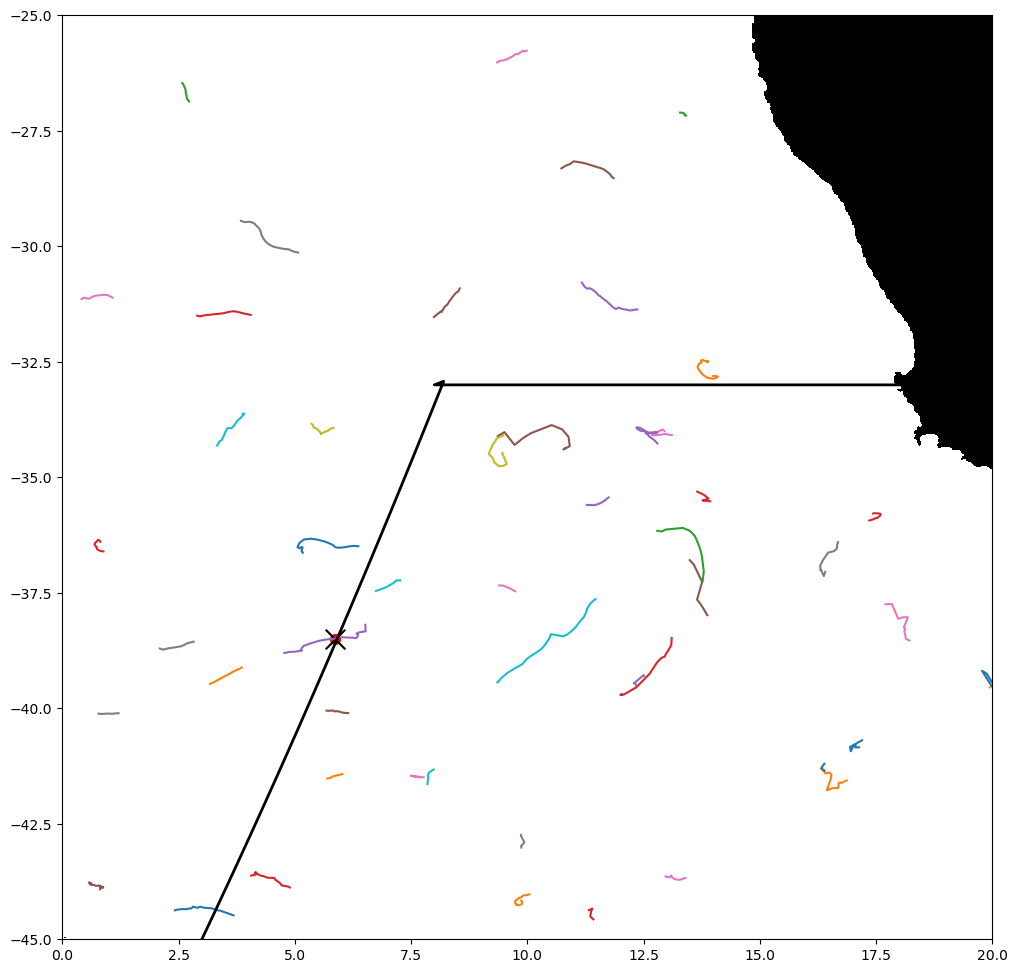

In [10]:
plt.figure(figsize=(12, 12))
with open(outpath + f'Good-hope-crossings_{datestart.replace("-", "")}_{dateend.replace("-", "")}_OW{np.abs(OW_thr_factor)}_Npix-{Npix_min}-{Npix_max}.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['type', 'lon', 'lat', 'time', 'duration',
                     'amp', 'scale', 'area',
                     'exist_at_start', 'terminated'])
    
    plt.contourf(mesh_mask.nav_lon, mesh_mask.nav_lat, mesh_mask.isel(z=0, t=0).tmask.where(mesh_mask.isel(z=0, t=0).tmask == 0), colors='black')
    for track in tracks:
        track_lon = track['lon']
        track_lat = track['lat']
        if len(track_lon) < minimum_duration or len(track_lat) < minimum_duration:
            continue
        plt.plot(track_lon, track_lat)
        
        crossed_left = check_if_crossed(track_lon, track_lat, line_left_lon, line_left_lat)
        crossed_up = check_if_crossed(track_lon, track_lat, line_up_lon, line_up_lat)

        if crossed_left is not None and crossed_up is not None:
            crossed = max(crossed_left, crossed_up)
        elif crossed_left is not None:
            crossed = crossed_left
        elif crossed_up is not None:
            crossed = crossed_up
        else:
            continue  # Keine Kreuzung -> überspringen
        
        #crossed = check_if_crossed(track_lon, track_lat, combined_lon, combined_lat)
        #if crossed is not None:
        plt.scatter(track_lon[crossed], track_lat[crossed], color='red', marker='o', s=50)
        plt.scatter(track_lon[crossed], track_lat[crossed], color='black', marker='x', s=200)
            
        time_of_crossing = start_date + timedelta(days=crossed) 
        writer.writerow([track['type'], track_lon[crossed], track_lat[crossed], str(time_of_crossing.date()), len(track_lon),
                             track['amp'][crossed], track['scale'][crossed], track['area'][crossed],
                             track['exist_at_start'], track['terminated']])
    
    plt.plot(combined_lon, combined_lat, color='black',linewidth=2)
    plt.xlim([0,20])
    plt.ylim([-45,-25]);